##### from tifresi import pyplot as plt
import numpy as np

import librosa
import librosa.display

%matplotlib inline
from IPython.display import display, Audio

import random

# Define the main parameters
* The number of frequency channel for the stft `stft_channels`
* The hop_size in time `hop_size`

In [37]:
# Here we use the default paramters. We recommend using them.
from tifresi.hparams import HParams
stft_channels = HParams.stft_channels # 1024
hop_size = HParams.hop_size # 256

import numpy as np
import random
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio, display

In [62]:
print(f'{HParams}')

<class 'tifresi.hparams.HParams'>


# Build the time frequency system
The system will be used for the following operation:
* Compute the STFT
* Compute the spectrogram
* Invert the STFT
* Reconstruc the phase and invert the spectrogram

In [38]:
from tifresi.stft import GaussTF, GaussTruncTF
# For faster processin, a truncated window can be used instead
use_truncated_window = True
if use_truncated_window:
    stft_system = GaussTruncTF(hop_size=hop_size, stft_channels=stft_channels)
else:
    stft_system = GaussTF(hop_size=hop_size, stft_channels=stft_channels)



## Set a few parameters

In [39]:
sr=44100
secs=2
n=secs*sr 
numframes=n//hop_size
numfreqs=int(stft_channels/2+1)

print(f"num freqs = {numfreqs}, num frames = {numframes}")

num freqs = 513, num frames = 344


# Construct the artificial spectrogram

In [54]:
Y=np.zeros((numfreqs, numframes))+.000001

maxbin=int(numfreqs/4)
xfatness=1
yfatness=25
repeats=40

signal="RANDOM"   #FATSWEEP, RANDOM

if signal=="FATSWEEP" :
    for j in range(numframes) :
        i=int((maxbin)*(j/numframes))
        for fat in range(yfatness) :
            Y[i+fat,j]=1
            
if signal=="RANDOM" :
    for reps in range(repeats) :
        i=random.randint(0, maxbin-yfatness-1)
        j=random.randint(0,numframes-xfatness-1)
        for ii in range(yfatness) :
            for jj in range(xfatness) :
                Y[i+ii,j+jj]=1
    

In [55]:
# We use the log spectrogram as we have a logarithmic perception of sound energy.
from tifresi.transforms import log_spectrogram
log_Y= log_spectrogram(Y)

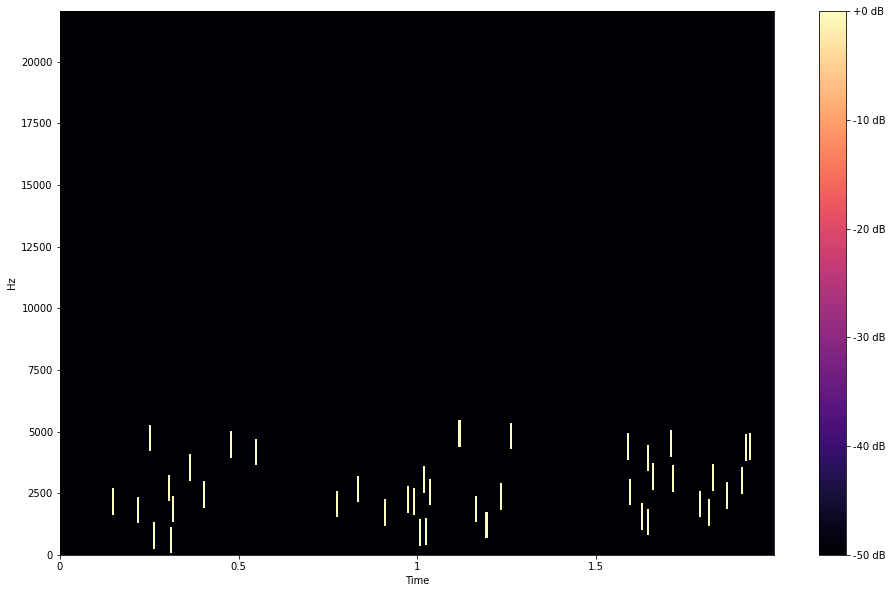

In [56]:

fig, ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(16)
img = librosa.display.specshow(log_Y, x_axis='time', y_axis='linear', sr=sr,ax=ax, hop_length=hop_size)
#ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")


# Invert the representation

In [57]:
from tifresi.transforms import inv_log_spectrogram
from tifresi.metrics import projection_loss

new_Y = inv_log_spectrogram(log_Y)
print(projection_loss(new_Y, Y))

78.47307162616198


In [58]:
new_y = stft_system.invert_spectrogram(new_Y)

In [59]:
from tifresi.metrics import projection_loss
new_Yp = stft_system.spectrogram(new_y)
print(projection_loss(new_Y, new_Yp))

4.006117711547724


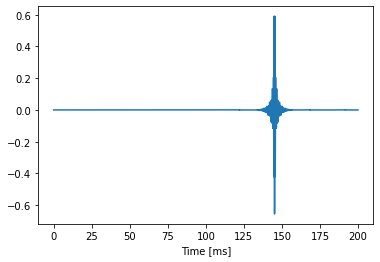

In [60]:
#show first secs/10 of the sound to see detail
t = np.arange(len(new_y))/sr*1000
plt.plot(t[:int(n/10)], new_y[:int(n/10)])
plt.xlabel('Time [ms]');


display(Audio(new_y, rate=sr))